In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [2]:
with open("/workspace/deception-detection/results/by_layer_repe_clean_10000_control_lr__repe_honesty__plain__llama-70b-3.3__20251214_152721/scores_by_layer.json", "r") as f:
    scores = json.load(f)

In [3]:
scores.keys()

dict_keys(['repe_honesty__plain_val', 'roleplaying_poisoned__plain', 'alpaca__plain'])

In [4]:
layer = 22
control_scores = scores["alpaca__plain"][str(layer)]
roleplaying_scores = scores["roleplaying_poisoned__plain"][str(layer)]

In [5]:
## Thresholding analysis
promptwise_control_scores = [np.mean(control_score) for control_score in control_scores["scores"]]
threshold = np.percentile(promptwise_control_scores, 99)
threshold

-3.9987510128722774

In [6]:
roleplaying_scores_all = roleplaying_scores["scores"]
roleplaying_labels_all = roleplaying_scores["labels"]
promptwise_roleplaying_scores = []
for i, label in enumerate(roleplaying_labels_all):
    if label == 'DECEPTIVE':
        promptwise_roleplaying_scores.append(np.mean(roleplaying_scores_all[i]))

In [7]:
all_scores = np.concatenate([promptwise_control_scores, promptwise_roleplaying_scores])
all_labels = [0]*len(promptwise_control_scores) + [1]*len(promptwise_roleplaying_scores)
if np.isnan(all_scores).any():
    print("NaN values found in scores!")
    all_labels = np.array(all_labels)
    all_scores = all_scores[~np.isnan(all_scores)]
    all_labels = all_labels[~np.isnan(all_scores)]
    
gt_labels = [1 if score > threshold else 0 for score in all_scores]
roc_auc = roc_auc_score(all_labels, gt_labels)
f1 = f1_score(all_labels, gt_labels)
precision = precision_score(all_labels, gt_labels)
recall = recall_score(all_labels, gt_labels)
print(f"Layer {layer} - ROC AUC: {roc_auc}, F1 Score: {f1}, Precision: {precision}, Recall: {recall}")

Layer 22 - ROC AUC: 0.945735914455077, F1 Score: 0.7530864197530864, Precision: 0.6466431095406361, Recall: 0.9014778325123153


##### Hard Ensemble (If one flags deceptive then label is deceptive) - AND of the predictions

In [8]:
all_layers_gt_labels = []
all_layer_predictions = []
for layer in tqdm(range(80)):
    control_scores = scores["alpaca__plain"][str(layer)]
    roleplaying_scores = scores["roleplaying_poisoned__plain"][str(layer)]
    
    ## Thresholding analysis
    promptwise_control_scores = [np.mean(control_score) for control_score in control_scores["scores"]]
    threshold = np.percentile(promptwise_control_scores, 99)
    
    roleplaying_scores_all = roleplaying_scores["scores"]
    roleplaying_labels_all = roleplaying_scores["labels"]
    promptwise_roleplaying_scores = []
    for i, label in enumerate(roleplaying_labels_all):
        if label == 'DECEPTIVE':
            promptwise_roleplaying_scores.append(np.mean(roleplaying_scores_all[i]))
    
    all_scores = np.concatenate([promptwise_control_scores, promptwise_roleplaying_scores])
    all_labels = [0]*len(promptwise_control_scores) + [1]*len(promptwise_roleplaying_scores)
    if np.isnan(all_scores).any():
        all_labels = np.array(all_labels)
        all_scores = all_scores[~np.isnan(all_scores)]
        all_labels = all_labels[~np.isnan(all_scores)]
    
    pred_labels = [1 if score > threshold else 0 for score in all_scores]
    all_layers_gt_labels.append(all_labels)
    all_layer_predictions.append(pred_labels)

  2%|▎         | 2/80 [00:00<00:04, 18.76it/s]

100%|██████████| 80/80 [00:04<00:00, 18.03it/s]


In [9]:
all_auroc_scores = [[] for _ in range(80)]
all_f1_scores = [[] for _ in range(80)]
all_precision_scores = [[] for _ in range(80)]
all_recall_scores = [[] for _ in range(80)]

In [10]:
for i in tqdm(range(80)):
    for j in (range(80)):
        layer_gt_labels = all_layers_gt_labels[i]
        layer_i_predictions = all_layer_predictions[i]
        layer_j_predictions = all_layer_predictions[j]
        hard_ensemble = (np.array(layer_i_predictions) & np.array(layer_j_predictions)).tolist()
        roc_auc = roc_auc_score(layer_gt_labels, hard_ensemble)
        f1 = f1_score(layer_gt_labels, hard_ensemble)
        precision = precision_score(layer_gt_labels, hard_ensemble)
        recall = recall_score(layer_gt_labels, hard_ensemble)
        all_auroc_scores[i].append(roc_auc)
        all_f1_scores[i].append(f1)
        all_precision_scores[i].append(precision)
        all_recall_scores[i].append(recall)

  0%|          | 0/80 [00:00<?, ?it/s]/workspace/intenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspace/intenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/workspace/intenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/w

In [ ]:
# F1 Score: 0.7530864197530864, Precision: 0.6466431095406361, Recall: 0.9014778325123153

In [37]:
best_auroc_score = 0.945735914455077
best_f1_score = 0.7530864197530864
best_precision_score = 0.6466431095406361
best_recall_score = 0.9014778325123153
filtered_all_auroc_scores = [[] for _ in range(80)]
filtered_all_f1_scores = [[] for _ in range(80)]
filtered_all_precision_scores = [[] for _ in range(80)]
filtered_all_recall_scores = [[] for _ in range(80)]
for i in range(80):
    for j in range(80):
        filtered_all_auroc_scores[i].append(all_auroc_scores[i][j] - best_auroc_score)
        filtered_all_f1_scores[i].append(all_f1_scores[i][j] - best_f1_score)
        filtered_all_precision_scores[i].append(all_precision_scores[i][j] - best_precision_score)
        filtered_all_recall_scores[i].append(all_recall_scores[i][j] - best_recall_score)

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, ListedColormap

def plot_pairwise_scores_strong_positive_highlight(
    scores,
    title=None,
    normalize=True,
):
    scores = np.asarray(scores, dtype=float)

    # Robust normalization
    if normalize:
        scale = np.nanpercentile(np.abs(scores), 99)
        if scale > 0:
            scores = scores / scale

    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

    fig, ax = plt.subplots(figsize=(7, 7))

    # Base heatmap (signed values)
    im = ax.imshow(
        scores,
        cmap="RdBu_r",
        norm=norm,
        interpolation="nearest",
        aspect="equal"
    )

    # Positive mask overlay
    pos_mask = scores > 0
    overlay = np.zeros_like(scores)
    overlay[pos_mask] = 1

    ax.imshow(
        overlay,
        cmap=ListedColormap(["none", "#ff0000"]),  # bright cyan
        interpolation="nearest",
        alpha=0.6
    )

    ax.set_xticks([])
    ax.set_yticks([])

    if title:
        ax.set_title(title)

    for spine in ax.spines.values():
        spine.set_visible(False)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Normalized score")


    fig.tight_layout()
    plt.show()


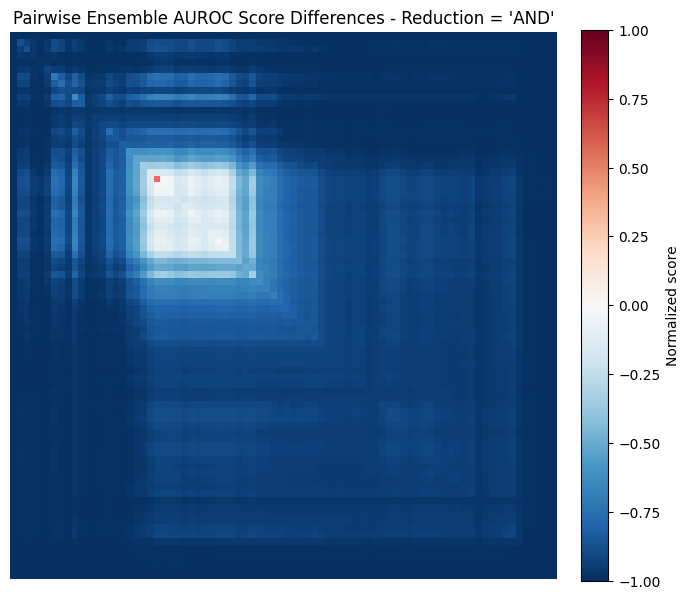

In [38]:
plot_pairwise_scores_strong_positive_highlight(
    filtered_all_auroc_scores,
    title="Pairwise Ensemble AUROC Score Differences - Reduction = 'AND'",
)

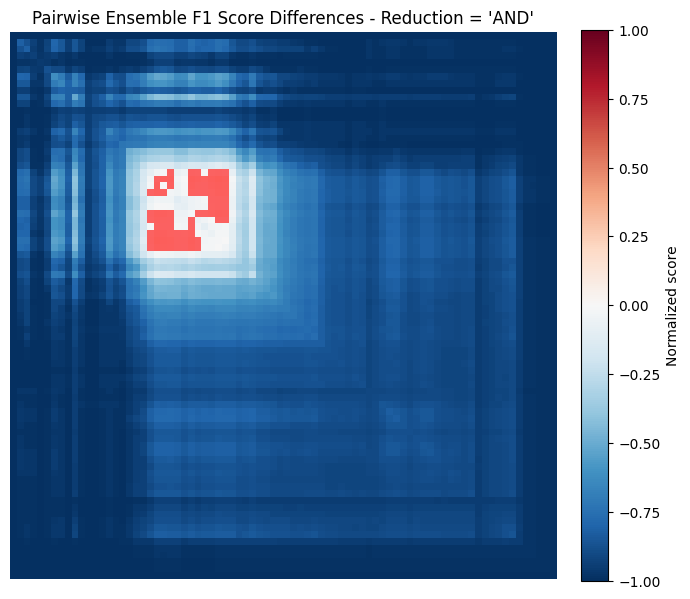

In [39]:
plot_pairwise_scores_strong_positive_highlight(
    filtered_all_f1_scores,
    title="Pairwise Ensemble F1 Score Differences - Reduction = 'AND'",
)

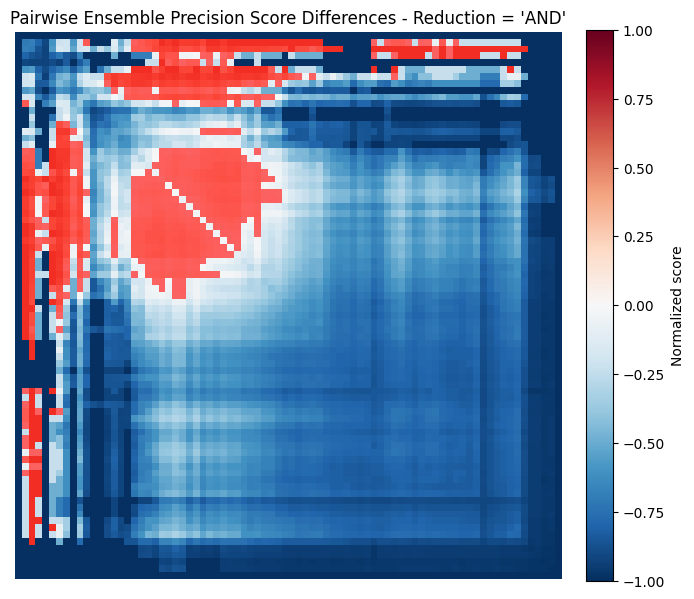

In [40]:
plot_pairwise_scores_strong_positive_highlight(
    filtered_all_precision_scores,
    title="Pairwise Ensemble Precision Score Differences - Reduction = 'AND'",
)

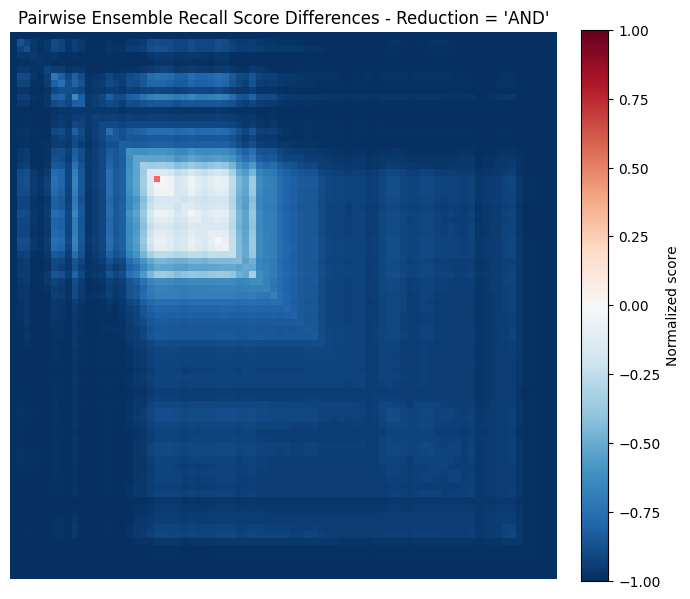

In [41]:
plot_pairwise_scores_strong_positive_highlight(
    filtered_all_recall_scores,
    title="Pairwise Ensemble Recall Score Differences - Reduction = 'AND'",
)